# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
#     env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    rewards.append(reward)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        rewards = []
        env.reset()

state, action, reward, done, info
[ 0.09300684  0.96111238 -0.23103371 -1.6758006 ] 0 1.0 True {}
state, action, reward, done, info
[-0.08779037 -0.17063081  0.22515187  0.6874258 ] 1 1.0 True {}
state, action, reward, done, info
[ 0.08641655  1.02550693 -0.23643418 -1.94287119] 1 1.0 True {}
state, action, reward, done, info
[ 0.15788145  0.61399144 -0.22909108 -1.20693463] 0 1.0 True {}
state, action, reward, done, info
[-0.08300004 -0.63287044  0.2144005   1.18074564] 1 1.0 True {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
class QNetwork:
    def __init__(self, state_size=4, action_size=2, hidden_size=10): #, training=True
            ######################## Data into the Model: make the data available inside the framework
            # Given data
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')

            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            #################### Create the Model: model loss and forward pass
            # First fully connected layer
            h1 = tf.layers.dense(inputs=self.inputs_, units=hidden_size)
            #bn1 = tf.layers.batch_normalization(h1, training=training)
            nl1 = tf.maximum(0.1 * h1, h1)

            # Second fully connected layer
            h2 = tf.layers.dense(nl1, hidden_size)
            #bn2 = tf.layers.batch_normalization(h2, training=training)
            nl2 = tf.maximum(0.1 * h2, h2)

            # Output layer
            self.output = tf.layers.dense(nl2, action_size)        

            # One hot encode the actions to later choose the Q-value for the action
            one_hot_actions = tf.one_hot(self.actions_, action_size)

            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)

            # error backpropagation: loss and opt
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            
            ########################### Update the model
            self.opt = tf.train.AdamOptimizer().minimize(self.loss)

In [6]:
# class QNetwork:
#     def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10, name='QNetwork'):
#         # state inputs to the Q-network
#         with tf.variable_scope(name):
#             # Given data
#             self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
#             self.actions_ = tf.placeholder(tf.int32, [None], name='actions')

#             # One hot encode the actions to later choose the Q-value for the action
#             one_hot_actions = tf.one_hot(self.actions_, action_size)

#             # ReLU hidden layers
#             fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
#             fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

#             # Linear output layer
#             self.output = tf.contrib.layers.fully_connected(fc2, action_size, activation_fn=None)
                    
#             ### Train with loss (targetQ - Q)^2
#             # output has length 2, for two actions. This next line chooses
#             # one value from output (per row) according to the one-hot encoded actions.
#             self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)

#             # Target Q values for training
#             self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')

#             # error backpropagation: loss and opt
#             self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
#             self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [7]:
# tf.layers.dense(
#     inputs, --- GOOD
#     units, ----- GOOD
#     activation=None,
#     use_bias=True,  ----------- GOOD
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), ----------GOOD
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ----------------- ???
#     name=None,
#     reuse=None
# )

In [8]:
# def generator(in_state, state_size=4, action_size=2, hidden_size=10, alpha=0.1, reuse=False, training=True):
#     with tf.variable_scope('generator', reuse=reuse):
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=in_state, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(nl1, hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits_state_next = tf.layers.dense(nl2, state_size, trainable=False)        
#         logits_action = tf.layers.dense(nl2, action_size, trainable=False)        
#         # out = tf.tanh(logits)

#         return logits_state_next, logits_action

In [9]:
# def discriminator(in_state_next, out_action, action_size=2, hidden_size=10, reuse=False, alpha=0.1):
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # First fully connected layer
#         fused = tf.concat(values=[in_state_next, out_action], axis=1)
#         h1 = tf.layers.dense(fused, hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=True)
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(nl1, hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=True)
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(nl2, 1, trainable=False)   
#         out = tf.sigmoid(logits)

#         # logits for loss and reward/prob/out
#         return out, logits

In [10]:
# def model_inputs(state_size=4):
#     # Current input states
#     inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs') # NxCin
#     # print(self.inputs_)

#     # Current output action: for generation/prediction
#     actions_ = tf.placeholder(tf.int32, [None], name='actions')
#     # print(actions_)

#     # Next input real and generated/fake/predicted
#     inputs_next = tf.placeholder(tf.float32, [None, state_size], name='inputs_next') # NxCin
#     # print(self.inputs_next)
    
#     return inputs_, actions_, inputs_next

In [11]:
# def model_loss(inputs_, actions_, inputs_next, action_size=2, hidden_size=10, alpha=0.1):
#     """
#     Get the loss for the discriminator and generator
#     :param inputs_: real input states given
#     :param actions_: real actions given
#     :param inputs_next: real next input states given
#     :return: A tuple of (discriminator loss, generator loss)
#     """
#     input_state_gen, out_action_gen = generator(in_state=inputs_, hidden_size=hidden_size)
#     _, d_logits_fake = discriminator(in_state_next=input_state_gen, out_action=out_action_gen, hidden_size=hidden_size)
#     actions_onehot = tf.one_hot(actions_, action_size)
#     _, d_logits_real = discriminator(in_state_next=inputs_next, out_action=actions_onehot, hidden_size=hidden_size, reuse=True)

#     d_loss_real = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
#     d_loss_fake = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
#     d_loss = d_loss_real + d_loss_fake
    
#     g_loss = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
#     return d_loss, g_loss

In [12]:
# def model_opt(d_loss, g_loss, learning_rate):
#     """
#     Get optimization operations
#     :param d_loss: Discriminator loss Tensor for reward function
#     :param g_loss: Generator loss Tensor for action & next state predicton
#     :param learning_rate: Learning Rate Placeholder
#     :return: A tuple of (discriminator training operation, generator training operation)
#     """
#     # Get weights and bias to update
#     t_vars = tf.trainable_variables()
#     d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
#     g_vars = [var for var in t_vars if var.name.startswith('generator')]

#     # Optimize
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

#     return d_train_opt, g_train_opt

In [13]:
# class Net:
#     def __init__(self, action_size=2, state_size=4, hidden_size=10, learning_rate=0.01, alpha=0.1):
#         tf.reset_default_graph()
        
#         # Transfer the data into the framework: model the input/given data
#         self.inputs_, self.actions_, self.inputs_next = model_inputs(state_size=state_size)
        
#         # Creating the model inside the framework: Model forward prop for caculating the loss
#         self.d_loss, self.g_loss = model_loss(inputs_=self.inputs_, actions_=self.actions_, inputs_next=self.inputs_next, 
#                                               hidden_size=hidden_size)
        
#         # Updating the model inside the framework: Model the backprop for updating the model
#         self.d_opt, self.g_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, learning_rate=learning_rate)

In [14]:
# # def generator(in_state, state_size=4, action_size=2, hidden_size=10, name='generator', reuse=False, ):
# #     # state inputs to the Q-network2
# #     with tf.variable_scope(name, reuse=reuse): # for saving the generator weights and biases (model parameters)

# #         # ReLU hidden layers: generators
# #         fc1 = tf.contrib.layers.fully_connected(in_state, hidden_size)
# #         fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

# #         # Linear output layer
# #         logits_state_next = tf.contrib.layers.fully_connected(fc2, state_size, activation_fn=None, trainable=False)
# #         logits_action = tf.contrib.layers.fully_connected(fc2, action_size, activation_fn=None, trainable=False)

# #         # # Split it into in and out
# #         # logits_state_next, logits_action = tf.split(value=logits, num_or_size_splits=[state_size, action_size], axis=1)

# #         # logits_action is for applying to the env or env.step and the predicted next state is for D
# #         return logits_state_next, logits_action

# # def discriminator(in_state_next, out_action, action_size=2, hidden_size=10, name='discriminator', reuse=False):
# #     # state inputs to the Q-network2
# #     with tf.variable_scope(name, reuse=reuse):
        
# #         # ReLU hidden layers: discriminator
# #         fused = tf.concat(values=[in_state_next, out_action], axis=1)
# #         # print(in_state_next.shape, out_action.shape, fused.shape)
# #         fc1 = tf.contrib.layers.fully_connected(fused, hidden_size)
# #         fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

# #         # Linear output layer: logits and prob/logistics
# #         logits = tf.contrib.layers.fully_connected(fc2, 1, activation_fn=None)
# #         # reward = tf.sigmoid(x=logits) # for reward accumulation -  reward: 0-1

# #         # outputing the logits and prob reward: logits for loss and prob for accumulaion
# #         return logits

# # # This GAN for iDRL
# class Net:
#     def __init__(self, state_size=4, action_size=2, hidden_size=10, learning_rate=0.01):            
#         # Current input states
#         self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs') # NxCin
#         # print(self.inputs_)

#         # Current output action: for generation/prediction
#         self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
#         actions_onehot = tf.one_hot(self.actions_, action_size)
#         # print(actions_onehot)

#         # Next input real and generated/fake/predicted
#         self.inputs_next = tf.placeholder(tf.float32, [None, state_size], name='inputs_next') # NxCin
#         # print(self.inputs_next)

#         # Linear output layer
#         inputs_next_gen, self.output_gen = generator(self.inputs_)

#         # Linear output layer
#         d_logits_fake = discriminator(inputs_next_gen, self.output_gen) # , self.d_reward_fake
#         d_logits_real = discriminator(self.inputs_next, actions_onehot, reuse=True) #, self.d_reward_real

#         d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_fake, 
#                                                       logits=tf.zeros_like(d_logits_fake))
#         d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_real, 
#                                                       logits=tf.ones_like(d_logits_real))

#         self.d_loss = d_loss_fake + d_loss_real
#         self.g_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_fake, 
#                                                       logits=tf.ones_like(d_logits_fake))

#         self.d_opt = tf.train.AdamOptimizer(learning_rate).minimize(self.d_loss)
#         self.g_opt = tf.train.AdamOptimizer(learning_rate).minimize(self.g_loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [15]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 10               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size

In [20]:
tf.reset_default_graph()
# mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)
mainQN = QNetwork(hidden_size=hidden_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [21]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Train episodes/epochs
    step = 0
    for ep in range(train_episodes):
        total_reward = 0
        
        # Env/agent step and minibatch training
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode is done/failed or not;
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)

            # Bellman equation
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            # Updating the model
            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/cartpole__.ckpt")

Episode: 0 Total reward: 5.0 Training loss: 1.3851 Explore P: 0.9995
Episode: 1 Total reward: 33.0 Training loss: 1.4345 Explore P: 0.9962
Episode: 2 Total reward: 12.0 Training loss: 1.2440 Explore P: 0.9951
Episode: 3 Total reward: 18.0 Training loss: 1.0053 Explore P: 0.9933
Episode: 4 Total reward: 25.0 Training loss: 1.2261 Explore P: 0.9908
Episode: 5 Total reward: 12.0 Training loss: 1.3733 Explore P: 0.9897
Episode: 6 Total reward: 22.0 Training loss: 1.4631 Explore P: 0.9875
Episode: 7 Total reward: 23.0 Training loss: 2.5884 Explore P: 0.9853
Episode: 8 Total reward: 16.0 Training loss: 1.9950 Explore P: 0.9837
Episode: 9 Total reward: 9.0 Training loss: 3.3496 Explore P: 0.9828
Episode: 10 Total reward: 13.0 Training loss: 5.4590 Explore P: 0.9816
Episode: 11 Total reward: 18.0 Training loss: 3.0984 Explore P: 0.9798
Episode: 12 Total reward: 16.0 Training loss: 4.6582 Explore P: 0.9783
Episode: 13 Total reward: 16.0 Training loss: 10.9692 Explore P: 0.9767
Episode: 14 Total

Episode: 114 Total reward: 40.0 Training loss: 2.9630 Explore P: 0.8055
Episode: 115 Total reward: 12.0 Training loss: 3.4184 Explore P: 0.8046
Episode: 116 Total reward: 10.0 Training loss: 102.9020 Explore P: 0.8038
Episode: 117 Total reward: 14.0 Training loss: 5.8092 Explore P: 0.8027
Episode: 118 Total reward: 8.0 Training loss: 199.1661 Explore P: 0.8020
Episode: 119 Total reward: 13.0 Training loss: 100.2234 Explore P: 0.8010
Episode: 120 Total reward: 14.0 Training loss: 106.3764 Explore P: 0.7999
Episode: 121 Total reward: 10.0 Training loss: 112.1956 Explore P: 0.7991
Episode: 122 Total reward: 16.0 Training loss: 91.5888 Explore P: 0.7978
Episode: 123 Total reward: 17.0 Training loss: 5.3191 Explore P: 0.7965
Episode: 124 Total reward: 10.0 Training loss: 7.2192 Explore P: 0.7957
Episode: 125 Total reward: 9.0 Training loss: 6.5806 Explore P: 0.7950
Episode: 126 Total reward: 10.0 Training loss: 103.6991 Explore P: 0.7942
Episode: 127 Total reward: 10.0 Training loss: 103.27

Episode: 227 Total reward: 85.0 Training loss: 23.0631 Explore P: 0.6090
Episode: 228 Total reward: 35.0 Training loss: 35.4532 Explore P: 0.6069
Episode: 229 Total reward: 32.0 Training loss: 52.4463 Explore P: 0.6050
Episode: 230 Total reward: 135.0 Training loss: 138.4869 Explore P: 0.5970
Episode: 231 Total reward: 35.0 Training loss: 3.9328 Explore P: 0.5949
Episode: 232 Total reward: 14.0 Training loss: 5.2993 Explore P: 0.5941
Episode: 233 Total reward: 23.0 Training loss: 35.3940 Explore P: 0.5928
Episode: 234 Total reward: 59.0 Training loss: 7.0409 Explore P: 0.5893
Episode: 235 Total reward: 27.0 Training loss: 19.5564 Explore P: 0.5878
Episode: 236 Total reward: 39.0 Training loss: 7.2014 Explore P: 0.5855
Episode: 237 Total reward: 40.0 Training loss: 5.7155 Explore P: 0.5832
Episode: 238 Total reward: 22.0 Training loss: 3.4442 Explore P: 0.5820
Episode: 239 Total reward: 31.0 Training loss: 4.9596 Explore P: 0.5802
Episode: 240 Total reward: 18.0 Training loss: 3.7278 Ex

Episode: 340 Total reward: 138.0 Training loss: 6.4287 Explore P: 0.3138
Episode: 341 Total reward: 84.0 Training loss: 219.2083 Explore P: 0.3113
Episode: 342 Total reward: 70.0 Training loss: 7.1202 Explore P: 0.3092
Episode: 343 Total reward: 199.0 Training loss: 2.6754 Explore P: 0.3033
Episode: 344 Total reward: 132.0 Training loss: 15.1804 Explore P: 0.2995
Episode: 345 Total reward: 154.0 Training loss: 9.5203 Explore P: 0.2950
Episode: 346 Total reward: 199.0 Training loss: 72.3489 Explore P: 0.2894
Episode: 347 Total reward: 164.0 Training loss: 12.1340 Explore P: 0.2849
Episode: 348 Total reward: 105.0 Training loss: 94.4785 Explore P: 0.2820
Episode: 349 Total reward: 80.0 Training loss: 9.9722 Explore P: 0.2798
Episode: 350 Total reward: 84.0 Training loss: 11.7107 Explore P: 0.2776
Episode: 351 Total reward: 99.0 Training loss: 709.1058 Explore P: 0.2749
Episode: 352 Total reward: 91.0 Training loss: 18.2162 Explore P: 0.2725
Episode: 353 Total reward: 60.0 Training loss: 

Episode: 452 Total reward: 199.0 Training loss: 1.1383 Explore P: 0.0489
Episode: 453 Total reward: 192.0 Training loss: 2.0290 Explore P: 0.0481
Episode: 454 Total reward: 154.0 Training loss: 6.1963 Explore P: 0.0475
Episode: 455 Total reward: 163.0 Training loss: 1.4518 Explore P: 0.0469
Episode: 456 Total reward: 170.0 Training loss: 1.1334 Explore P: 0.0463
Episode: 457 Total reward: 199.0 Training loss: 1.1061 Explore P: 0.0456
Episode: 458 Total reward: 199.0 Training loss: 415.4126 Explore P: 0.0449
Episode: 459 Total reward: 193.0 Training loss: 1.4844 Explore P: 0.0442
Episode: 460 Total reward: 163.0 Training loss: 4.4294 Explore P: 0.0437
Episode: 461 Total reward: 163.0 Training loss: 6.9411 Explore P: 0.0431
Episode: 462 Total reward: 117.0 Training loss: 3.0052 Explore P: 0.0427
Episode: 463 Total reward: 94.0 Training loss: 1.9889 Explore P: 0.0424
Episode: 464 Total reward: 14.0 Training loss: 2.1375 Explore P: 0.0424
Episode: 465 Total reward: 10.0 Training loss: 2.65

Episode: 564 Total reward: 199.0 Training loss: 17.8983 Explore P: 0.0235
Episode: 565 Total reward: 199.0 Training loss: 13.6947 Explore P: 0.0232
Episode: 566 Total reward: 199.0 Training loss: 3.5435 Explore P: 0.0230
Episode: 567 Total reward: 199.0 Training loss: 11.5238 Explore P: 0.0227
Episode: 568 Total reward: 199.0 Training loss: 106.1741 Explore P: 0.0225
Episode: 569 Total reward: 199.0 Training loss: 3.3648 Explore P: 0.0222
Episode: 570 Total reward: 199.0 Training loss: 9.2249 Explore P: 0.0220
Episode: 571 Total reward: 199.0 Training loss: 10.0909 Explore P: 0.0217
Episode: 572 Total reward: 199.0 Training loss: 7.6330 Explore P: 0.0215
Episode: 573 Total reward: 199.0 Training loss: 3.8025 Explore P: 0.0213
Episode: 574 Total reward: 199.0 Training loss: 5.7361 Explore P: 0.0211
Episode: 575 Total reward: 198.0 Training loss: 5.1345 Explore P: 0.0208
Episode: 576 Total reward: 169.0 Training loss: 3.5870 Explore P: 0.0207
Episode: 577 Total reward: 166.0 Training los

Episode: 676 Total reward: 199.0 Training loss: 0.4157 Explore P: 0.0116
Episode: 677 Total reward: 199.0 Training loss: 0.6988 Explore P: 0.0115
Episode: 678 Total reward: 199.0 Training loss: 0.5675 Explore P: 0.0115
Episode: 679 Total reward: 199.0 Training loss: 0.6096 Explore P: 0.0115
Episode: 680 Total reward: 199.0 Training loss: 0.9568 Explore P: 0.0114
Episode: 681 Total reward: 199.0 Training loss: 0.6921 Explore P: 0.0114
Episode: 682 Total reward: 199.0 Training loss: 1.0607 Explore P: 0.0114
Episode: 683 Total reward: 199.0 Training loss: 0.4199 Explore P: 0.0114
Episode: 684 Total reward: 199.0 Training loss: 0.6658 Explore P: 0.0113
Episode: 685 Total reward: 199.0 Training loss: 0.4372 Explore P: 0.0113
Episode: 686 Total reward: 199.0 Training loss: 0.4287 Explore P: 0.0113
Episode: 687 Total reward: 199.0 Training loss: 0.3205 Explore P: 0.0113
Episode: 688 Total reward: 199.0 Training loss: 0.9733 Explore P: 0.0112
Episode: 689 Total reward: 199.0 Training loss: 0.5

Episode: 789 Total reward: 199.0 Training loss: 0.2581 Explore P: 0.0102
Episode: 790 Total reward: 199.0 Training loss: 0.7389 Explore P: 0.0102
Episode: 791 Total reward: 199.0 Training loss: 2.0711 Explore P: 0.0102
Episode: 792 Total reward: 199.0 Training loss: 0.7108 Explore P: 0.0102
Episode: 793 Total reward: 199.0 Training loss: 0.5719 Explore P: 0.0102
Episode: 794 Total reward: 199.0 Training loss: 0.5437 Explore P: 0.0102
Episode: 795 Total reward: 199.0 Training loss: 336.8263 Explore P: 0.0102
Episode: 796 Total reward: 199.0 Training loss: 0.8360 Explore P: 0.0101
Episode: 797 Total reward: 199.0 Training loss: 0.2786 Explore P: 0.0101
Episode: 798 Total reward: 199.0 Training loss: 0.6241 Explore P: 0.0101
Episode: 799 Total reward: 199.0 Training loss: 0.3725 Explore P: 0.0101
Episode: 800 Total reward: 199.0 Training loss: 0.3477 Explore P: 0.0101
Episode: 801 Total reward: 199.0 Training loss: 0.9373 Explore P: 0.0101
Episode: 802 Total reward: 199.0 Training loss: 1

Episode: 902 Total reward: 199.0 Training loss: 0.3238 Explore P: 0.0100
Episode: 903 Total reward: 199.0 Training loss: 0.8262 Explore P: 0.0100
Episode: 904 Total reward: 199.0 Training loss: 0.5314 Explore P: 0.0100
Episode: 905 Total reward: 199.0 Training loss: 0.9504 Explore P: 0.0100
Episode: 906 Total reward: 199.0 Training loss: 1.3381 Explore P: 0.0100
Episode: 907 Total reward: 199.0 Training loss: 0.5338 Explore P: 0.0100
Episode: 908 Total reward: 199.0 Training loss: 1.3202 Explore P: 0.0100
Episode: 909 Total reward: 199.0 Training loss: 0.8014 Explore P: 0.0100
Episode: 910 Total reward: 199.0 Training loss: 0.6852 Explore P: 0.0100
Episode: 911 Total reward: 199.0 Training loss: 2.1641 Explore P: 0.0100
Episode: 912 Total reward: 199.0 Training loss: 0.7476 Explore P: 0.0100
Episode: 913 Total reward: 199.0 Training loss: 2.4612 Explore P: 0.0100
Episode: 914 Total reward: 199.0 Training loss: 0.1855 Explore P: 0.0100
Episode: 915 Total reward: 199.0 Training loss: 1.2

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

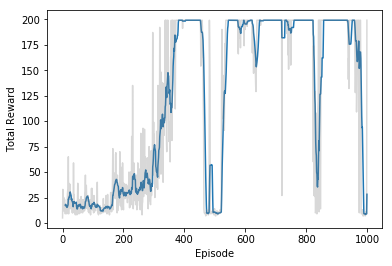

In [24]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.